# Проектная работа: Прогнозирование заказов такси

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

**Целью** данной работы является построение модели для предсказания количества заказов такси на следующий час.

**Условия задачи**: 
- значение метрики RMSE на тестовой выборке должно быть не больше 48;
- тестовая выборка должна составить 10% от исходных данных.

**План работы**:

1. Загрузка данных и ресемплирование по одному часу;
2. Анализ данных;
3. Обучение разных моделей с различными гиперпараметрами;
4. Проверка модели на тестовой выборке и выводы.

### Шаг 1. Загрузка данных и ресемплирование по одному часу

##### Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from catboost import CatBoostRegressor, Pool, metrics, cv


%matplotlib inline

In [2]:
df = pd.read_csv("taxi.csv")
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
df.shape

(26496, 2)

In [4]:
df.columns

Index(['datetime', 'num_orders'], dtype='object')

In [5]:
df.dtypes

datetime      object
num_orders     int64
dtype: object

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


### Выводы
---
Нам представлен одномерный временной ряд. Датасет содержит количество заказов такси каждые 10 минут в период с 1 марта по 31 августа 2018 г., всего насчитывает почти 26,5 тыс. строк. В столбце `datetime` мы поменяем тип данных на `datetime` и укажем его как индекс датасета, чтобы иметь возможность выполнять разные операции с данными (например, ресемплирование). Пропущенных значений нет. 

##### Ресемплирование по одному часу

In [7]:
# поменяем тип данных в столбце datetime
df["datetime"] = pd.to_datetime(df["datetime"], format = "%Y-%m-%d %H:%M:%S")

In [8]:
# проверим тип данных в столбце datetime после изменения
df.dtypes

datetime      datetime64[ns]
num_orders             int64
dtype: object

In [9]:
# укажем столбец datetime в качестве индекса датасета
df = df.set_index("datetime")
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [10]:
# проверим, что данные отсортированы в хронологическом порядке
print(df.index.is_monotonic)

True


In [11]:
# ресемплируем по одному часу
df = df.resample("1H").sum()

In [12]:
# проверим результаты ресемплирования
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [13]:
# размерность временного ряда после ресемплирования
df.shape

(4416, 1)

### Выводы
---
Итак, мы ресемплировали данные по одному часу. Теперь необходимо проанализировать временной ряд на стационарность (в этом поможет тест Дики-Фуллера), сезонность, наличие сезонности и шума, а также выбрать подходящие для прогнозирования модели.

### Шаг 2. Анализ данных

График самого временного ряда, где даны количество заказов по часам, не является репрезентативным из-за большого количества точек на графике, то есть сделать какие-то выводы по нему будет сложно. Поэтому укрупним данные до одного дня и посмотрим на такой график.

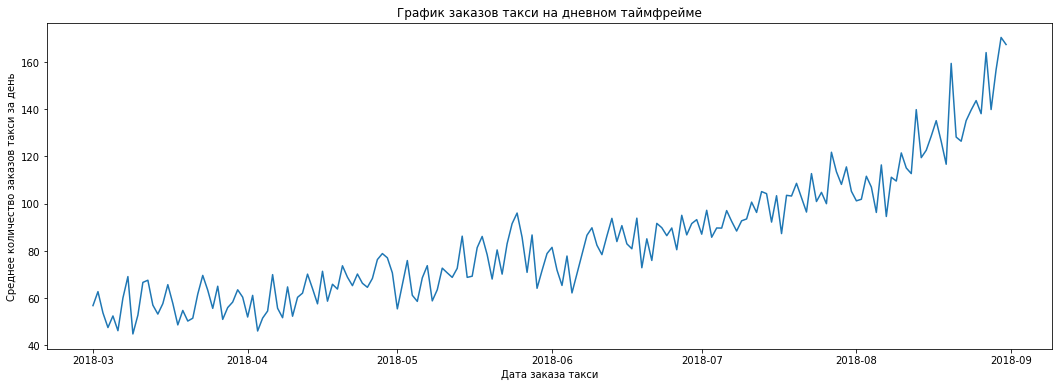

In [14]:
# посмотрим на график заказов такси в более укрупненном виде
plt.figure(figsize = (18, 6))
plt.plot(df.resample("1D").mean())
plt.title("График заказов такси на дневном таймфрейме")
plt.xlabel("Дата заказа такси")
plt.ylabel("Среднее количество заказов такси за день")
plt.show()

На графике видим, что наш временной ряд имеет возрастающий тренд. Рост числа заказов такси в аэропортах начинается ближе к летним месяцам года, то есть в период отпусков, когда люди чаще путешествуют. 

Так как мы анализируем временной ряд, то нам важно понять, является ли ряд стационарным. Во-первых, мы выполним декомпозицию на тренд, сезонность и остатки. Если у нашего временного ряда есть тренд, то мы дополнительно убедимся в этом. Наличие тренда является первым сигналом о том, что временной ряд является нестационарным. Важно также посмотреть наличие сезонности. Далее мы сделаем тест Дики-Фуллера, суть которой заключается в проверке временного ряда на стационарность.

In [15]:
decomposed_1h = seasonal_decompose(df)

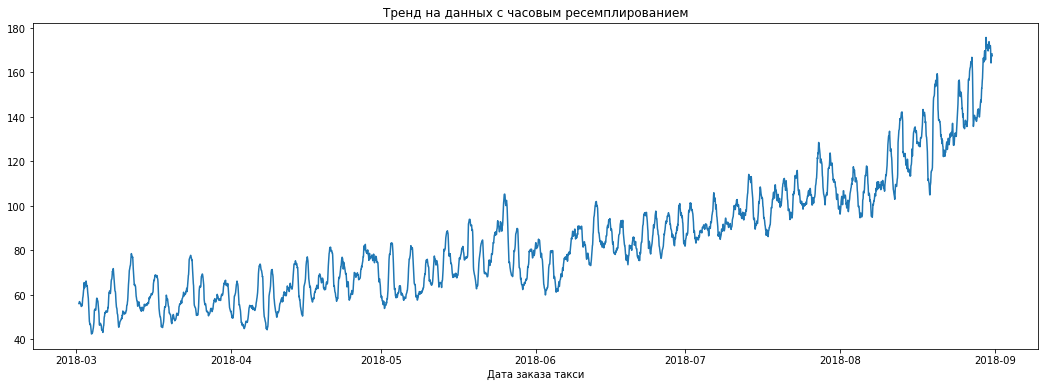

In [16]:
plt.figure(figsize = (18, 6))
plt.plot(decomposed_1h.trend)
plt.title("Тренд на данных с часовым ресемплированием")
plt.xlabel("Дата заказа такси")
plt.show()

Возрастающий тренд подтверждается на декомпозиции.

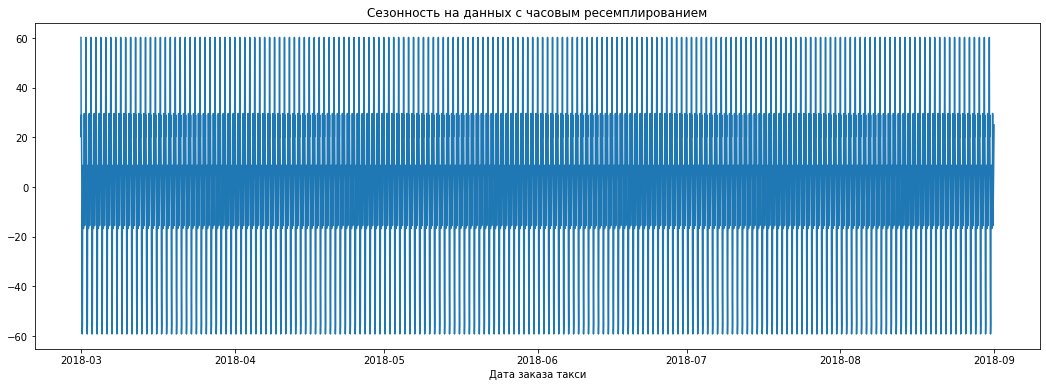

In [17]:
plt.figure(figsize = (18, 6))
plt.plot(decomposed_1h.seasonal)
plt.title("Сезонность на данных с часовым ресемплированием")
plt.xlabel("Дата заказа такси")
plt.show()

Если мы рассмотрим график сезонности на данных с часовым ресемплированием за весь доступный нам период, то мы вряд ли можем сделать какой-то вывод. Поэтому сузим период до одной недели.

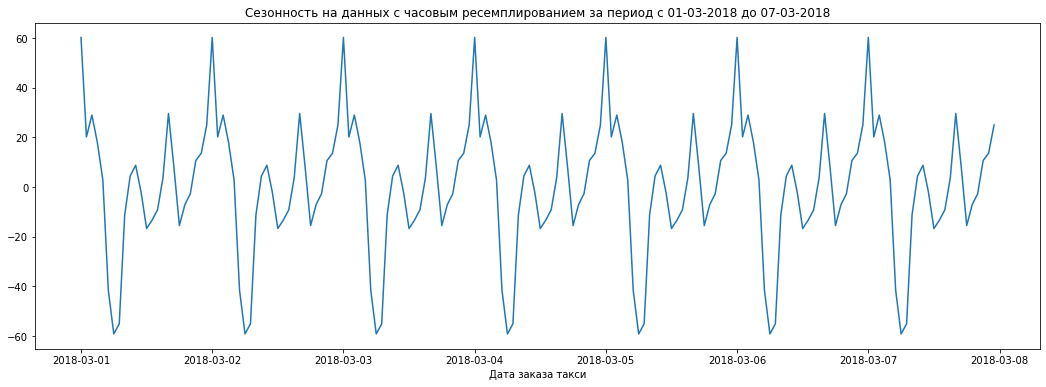

In [18]:
plt.figure(figsize = (18, 6))
plt.plot(decomposed_1h.seasonal["2018-03-01" : "2018-03-07"])
plt.title("Сезонность на данных с часовым ресемплированием за период с 01-03-2018 до 07-03-2018")
plt.xlabel("Дата заказа такси")
plt.show()

Таким образом, мы видим, что в наших данных есть суточная сезонность.

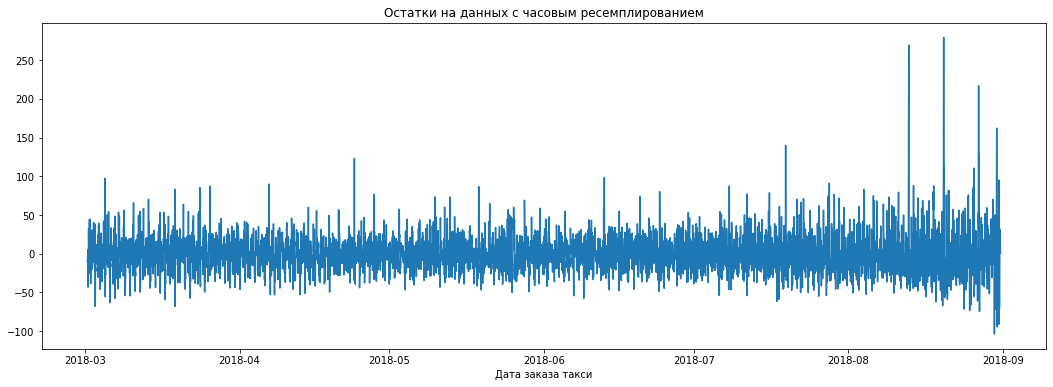

In [19]:
plt.figure(figsize = (18, 6))
plt.plot(decomposed_1h.resid)
plt.title("Остатки на данных с часовым ресемплированием")
plt.xlabel("Дата заказа такси")
plt.show()

Мы можем предполагать, что поведение клиентов может повторяться от недели к неделю. Поэтому проверим недельную сезонность.

In [20]:
df_24h = df.resample("24H").sum()
decomposed_24h = seasonal_decompose(df_24h)

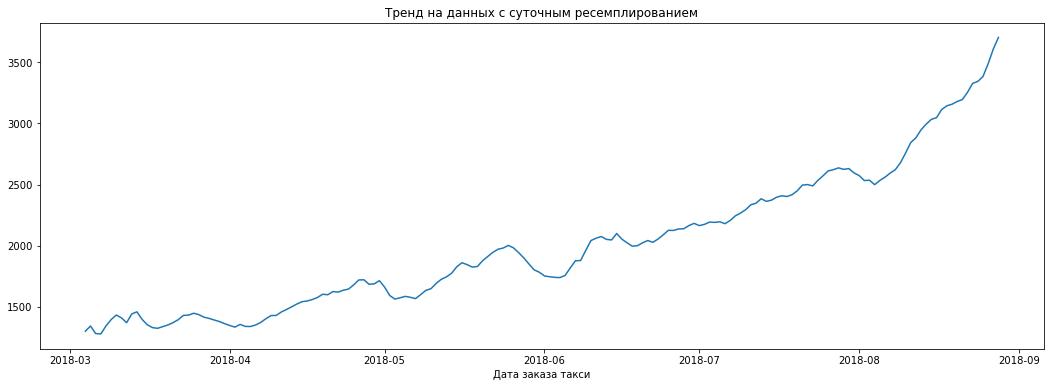

In [21]:
plt.figure(figsize = (18, 6))
plt.plot(decomposed_24h.trend)
plt.title("Тренд на данных с суточным ресемплированием")
plt.xlabel("Дата заказа такси")
plt.show()

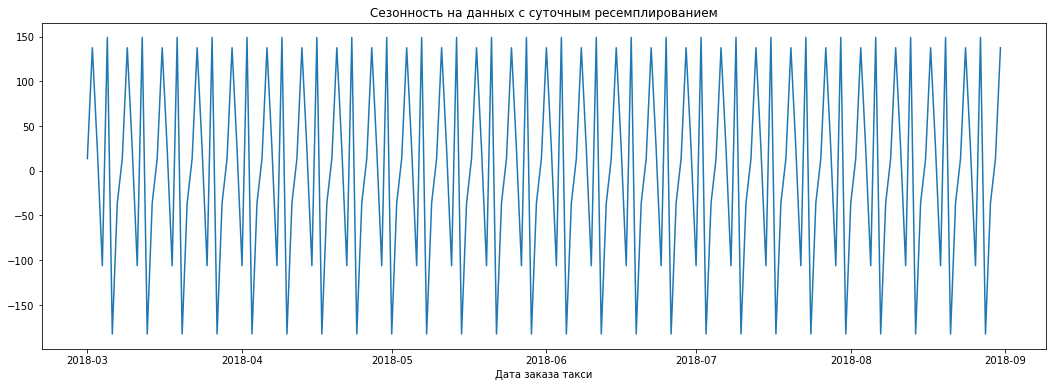

In [22]:
plt.figure(figsize = (18, 6))
plt.plot(decomposed_24h.seasonal)
plt.title("Сезонность на данных с суточным ресемплированием")
plt.xlabel("Дата заказа такси")
plt.show()

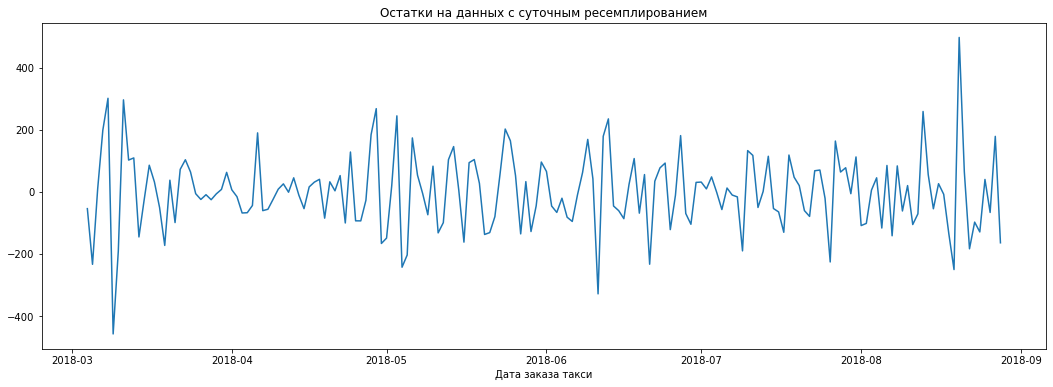

In [23]:
plt.figure(figsize = (18, 6))
plt.plot(decomposed_24h.resid)
plt.title("Остатки на данных с суточным ресемплированием")
plt.xlabel("Дата заказа такси")
plt.show()

Как видно на графике сезонности на данных с суточным ресемплированием, в нашем временном ряду действительно есть суточная сезонность. Теперь проведем тест Дики-Фуллра. Мы ожидаем, что тест подтвердит нестационарность временного ряда.

Для проведения теста Дики-Фуллера напишем функцию.

In [24]:
def check_stationarity(series):

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [25]:
check_stationarity(df)

ADF Statistic: -3.068924
p-value: 0.028940
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Stationary


На 5%-ом уровне значимости мы принимаем альтернативную гипотезу о том, что временной ряд является стационарным. Значит, мы можем построить графики корреляционной и автокорреляционной функций.

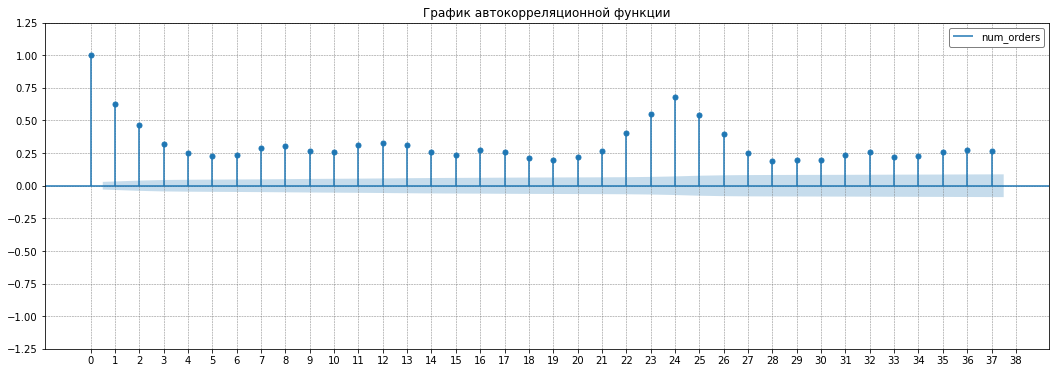

In [26]:
fig, ax = plt.subplots(figsize = (18, 6), nrows = 1, ncols = 1)
plot_acf(df["num_orders"], alpha = 0.05, title = "График автокорреляционной функции", ax = ax)
ax.legend(["num_orders"], loc = 0, framealpha = 1, edgecolor = "grey", shadow = None)
ax.grid(which = "major", color = "grey", linestyle = "--", linewidth = 0.5)
ax.set_yticks(np.arange(-1.25, 1.5, 0.25))
ax.set_xticks(np.arange(0, 39, 1));

График автокорреляционной функции имеет волнообразный вид. Мы видим, что с текущим наблюдением затухающую корреляцию имеют несколько лагов после него. Аналогичная картина повторяется ближе к 24 лагу, то есть через сутки. При этом, несколько лагов до 24 лага и после него также имеют высокую корреляцию с текущим наблюдением. 

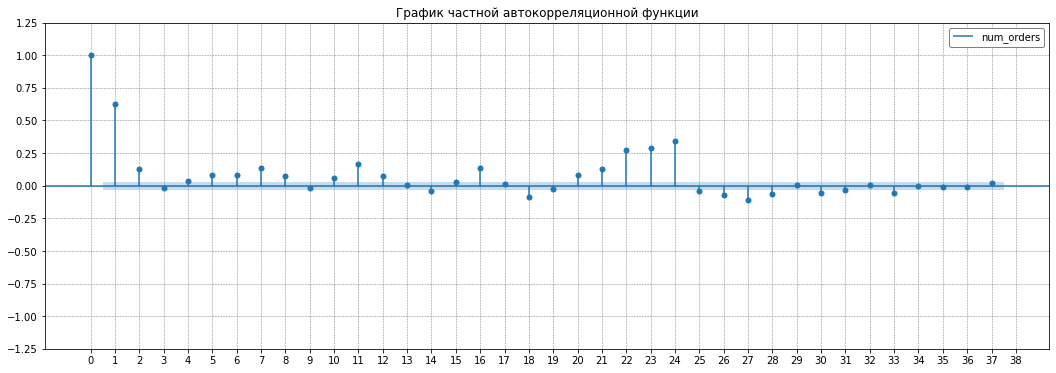

In [27]:
fig, ax = plt.subplots(figsize = (18, 6))
plot_pacf(df["num_orders"], method='ols', alpha = 0.05, 
          title = "График частной автокорреляционной функции", ax = ax)
ax.legend(["num_orders"], loc = 0, framealpha = 1, edgecolor = "grey", shadow = None)
ax.grid(which = "major", color = "grey", linestyle = "--", linewidth = 0.5)
ax.set_yticks(np.arange(-1.25, 1.5, 0.25))
ax.set_xticks(np.arange(0, 39, 1));

На частной автокорреляционной функции первый лаг имеют высокую корреляцию с текущим наблюдением, небольшой рост видно ближе к 24 лагу. Остальные лаги имеют незначительные корреляции с текущим наблюдением.

Формально тест Дики-Фуллера показывает стационарность временного ряда. Однако мы будем придерживаться консервативного подхода, потому что:

1. дисперсия временного ряда меняется со временем;
2. временной ряд содержит тренд;
3. два вида сезонностей (суточная и недельная) были определены.

Поэтому приведем наш временной к стационарному виду с помощью сезонного дифференцирования.

Прежде, чем мы приступим к устранению стационарности, посмотри также, как скользящее среднее ложится на график нашего временного ряда.

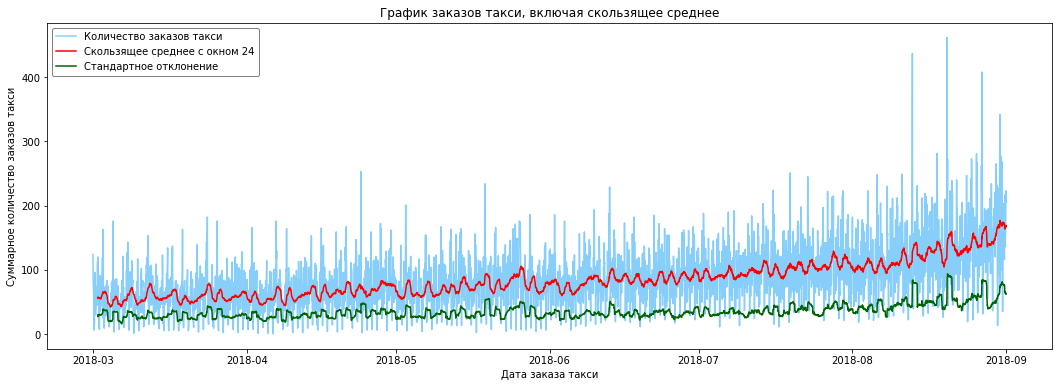

In [28]:
plt.figure(figsize = (18, 6))
plt.plot(df, label = "Количество заказов такси", color = "lightskyblue")
plt.plot(df.rolling(24).mean(), label = "Скользящее среднее с окном 24", color = "red")
plt.plot(df.rolling(24).std(), label = "Стандартное отклонение", color = "darkgreen")
plt.title("График заказов такси, включая скользящее среднее")
plt.xlabel("Дата заказа такси")
plt.ylabel("Суммарное количество заказов такси")
plt.legend(loc = 0, framealpha = 1, edgecolor = "grey", shadow = None)
plt.show()

Сглаживание колебаний в данных графически началось проявляться со значения окна в 24, то есть при рассчете среднего значения за предыдущие 24 наблюдений (или за день). Поэтому применим именно суточную дифференциацию.

In [29]:
df = df - df.shift(24)
print("Количество пропущенных значений во временном ряду после применения дифференцирования:", 
      df["num_orders"].isna().sum())

Количество пропущенных значений во временном ряду после применения дифференцирования: 24


Пропущенные значения мы удалим из временного ряда.

In [30]:
df = df.dropna()
print("Количество пропущенных значений во временном ряду после удаления пропущенных значений:", 
      df["num_orders"].isna().sum())

Количество пропущенных значений во временном ряду после удаления пропущенных значений: 0


In [31]:
print("Размерность временного ряда после всех изменений:", df.shape)

Размерность временного ряда после всех изменений: (4392, 1)


Проверим стационарность временного ряда после применения сезонного дифференцирования.

In [32]:
decomposed_final = seasonal_decompose(df)

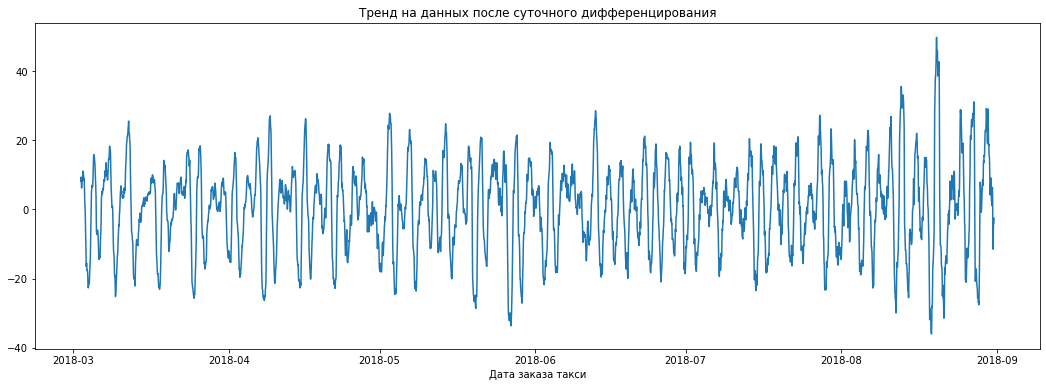

In [33]:
plt.figure(figsize = (18, 6))
plt.plot(decomposed_final.trend)
plt.title("Тренд на данных после суточного дифференцирования")
plt.xlabel("Дата заказа такси")
plt.show()

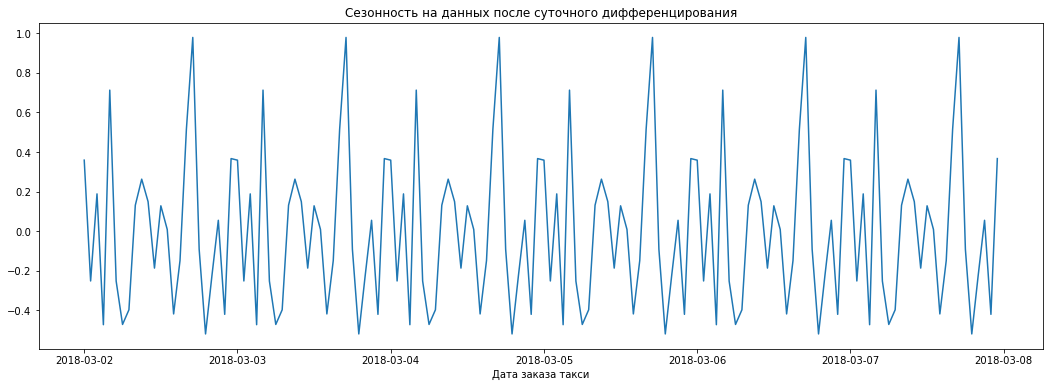

In [34]:
plt.figure(figsize = (18, 6))
plt.plot(decomposed_final.seasonal["2018-03-01" : "2018-03-07"])
plt.title("Сезонность на данных после суточного дифференцирования")
plt.xlabel("Дата заказа такси")
plt.show()

In [35]:
check_stationarity(df)

ADF Statistic: -16.006154
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Stationary


### Выводы
---
В результате анализа у нас сложилось определенное понимание того, как устроен наш временной ряд. Мы выявили суточную и недельную сезонности во временном ряду. Хотя и тест Дики-Фуллера показал стационарность ряда, мы придержались консервативного подхода, исходя из построенных графиков. В дальнейшем мы можем использовать сезонную модель $ARMA$. Также мы добавим признаки в наш временной ряд и оценим модели (от простой регрессии до градиентного бустинга).

### Шаг 3. Обучение разных моделей с различными гиперпараметрами

Создадим функцию для добавления в датасет новых признаков.

In [36]:
def make_features(data, max_lag, rolling_mean_size):
    data["hour"] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [37]:
make_features(df, 24, 24)
# пропуски в значениях, которые появились в результате создания новых признаков, заполнить мы не сможем
# поэтому удалим строки с пропусками
df = df.dropna()
print("Размерность датасета после создания новых признаков:", df.shape)

Размерность датасета после создания новых признаков: (4368, 28)


Теперь поделим данные на обучающую и тестовую выборки.

In [38]:
train, test = train_test_split(df, test_size = 0.1, shuffle = False)

features_train = train.drop("num_orders", axis = 1)
target_train = train["num_orders"]

features_test = test.drop("num_orders", axis = 1)
target_test = test["num_orders"]

print("Размерность признаков из обучающего набора данных:", features_train.shape)
print("Размерность таргета из обучающего набора данных:", target_train.shape)
print("Размерность признаков из тестового набора данных:", features_test.shape)
print("Размерность таргета из тестового набора данных:", target_test.shape)

Размерность признаков из обучающего набора данных: (3931, 27)
Размерность таргета из обучающего набора данных: (3931,)
Размерность признаков из тестового набора данных: (437, 27)
Размерность таргета из тестового набора данных: (437,)


##### Сезонный ARMA

In [39]:
sarima = SARIMAX(target_train,
                order = (1,0,1),
                seasonal_order = (1,0,1,24))
sarima_fit = sarima.fit(disp = 0)
print(sarima_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         num_orders   No. Observations:                 3931
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood              -17714.071
Date:                            Thu, 15 Dec 2022   AIC                          35438.142
Time:                                    21:55:29   BIC                          35469.526
Sample:                                03-03-2018   HQIC                         35449.277
                                     - 08-13-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9096      0.015     60.844      0.000       0.880       0.939
ma.L1         -0.7699      0.021   

Прежде чем использовать эту модель для прогнозирования временных рядов, мы должны убедиться, что наша модель собрала адекватную информацию из данных. Мы можем проверить это, посмотрев на остатки. Если модель хороша, ее остатки должны выглядеть как белый шум.

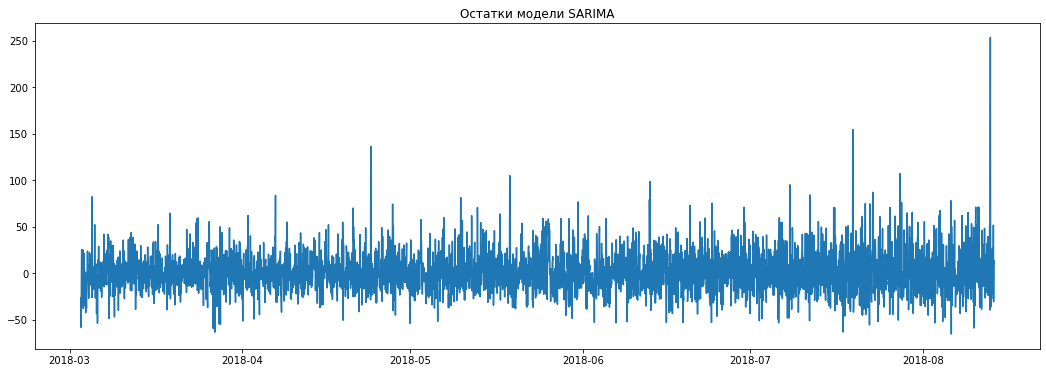

In [40]:
residuals = sarima_fit.resid[1:]

plt.figure(figsize = (18, 6))
plt.plot(residuals)
plt.title("Остатки модели SARIMA")
plt.show()

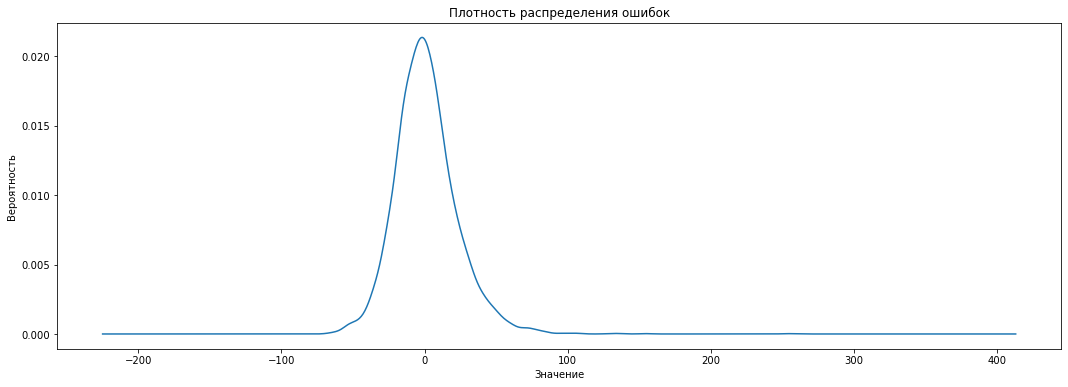

In [41]:
plt.figure(figsize = (18, 6))
residuals.plot(kind='kde')
plt.title("Плотность распределения ошибок")
plt.ylabel("Вероятность")
plt.xlabel("Значение")
plt.show()

In [42]:
forecast_train = sarima_fit.forecast(len(target_train))

In [43]:
print("RMSE для sARIMA модели на обучающей выборке:", 
      np.sqrt(mean_squared_error(target_train, forecast_train)).round(4))

RMSE для sARIMA модели на обучающей выборке: 32.1648


##### Линейная модель

In [44]:
simple_linear_model = GridSearchCV(
    LinearRegression(), param_grid = {"fit_intercept" : ["True", "False"]},
    cv = TimeSeriesSplit(n_splits = 5), scoring = "neg_root_mean_squared_error"
)

In [45]:
%%timeit

simple_linear_model.fit(features_train, target_train)

50.6 ms ± 3.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [46]:
simple_linear_model.best_params_

{'fit_intercept': 'True'}

In [47]:
print("RMSE для линейной модели на обучающей выборке:", abs(simple_linear_model.best_score_).round(4))

RMSE для линейной модели на обучающей выборке: 26.0812


##### Ridge-регрессия

In [48]:
ridge_regression_model = GridSearchCV(
    Ridge(random_state = 12345),
    param_grid = {"alpha" : [0.1, 1, 10, 100], 'solver' : ['auto', 'svd', 'cholesky', 'lsqr','sparse_cg']},
    cv = TimeSeriesSplit(n_splits = 5), scoring = "neg_root_mean_squared_error"
)

In [49]:
%%timeit

ridge_regression_model.fit(features_train, target_train)

464 ms ± 25.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
ridge_regression_model.best_params_

{'alpha': 100, 'solver': 'lsqr'}

In [51]:
print("RMSE для Ridge регрессии на обучающей выборке:", abs(ridge_regression_model.best_score_).round(4))

RMSE для Ridge регрессии на обучающей выборке: 26.0796


##### LASSO-регрессия

In [52]:
lasso_regression_model = GridSearchCV(
    Lasso(random_state = 12345),
    param_grid = {"alpha" : [0.01, 0.1, 1, 10, 100]},
    cv = TimeSeriesSplit(n_splits = 5), scoring = "neg_root_mean_squared_error"
)

In [53]:
%%timeit

lasso_regression_model.fit(features_train, target_train)

242 ms ± 17.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
lasso_regression_model.best_params_

{'alpha': 10}

In [55]:
print("RMSE для Lasso-регрессии на обучающей выборке:", abs(lasso_regression_model.best_score_).round(4))

RMSE для Lasso-регрессии на обучающей выборке: 25.9782


##### LGBM-регрессия

In [56]:
lgbm_regression_model = GridSearchCV(
    lgb.LGBMRegressor(random_state = 12345),
    param_grid = {"learning_rate" : np.arange(0.1, 1.1, 0.2), "max_depth" : np.arange(1, 11)},
    cv = TimeSeriesSplit(n_splits = 5), scoring = "neg_root_mean_squared_error"
)

In [57]:
%%timeit

lgbm_regression_model.fit(features_train, target_train)

10.4 s ± 177 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
lgbm_regression_model.best_params_

{'learning_rate': 0.1, 'max_depth': 2}

In [59]:
print("RMSE для LGBM-регрессии на обучающей выборке:", abs(lgbm_regression_model.best_score_).round(4))

RMSE для LGBM-регрессии на обучающей выборке: 25.5434


##### CatBoost-регрессия

In [60]:
train_pool = Pool(features_train, target_train, cat_features = ["hour", "dayofweek"])
test_pool = Pool(features_test, target_test, cat_features = ["hour", "dayofweek"])

In [61]:
catboost_regression_model = CatBoostRegressor(iterations = 1000, verbose = False, random_state = 12345)

In [62]:
grid = {
    'learning_rate': [0.03, 0.1],
    'depth':[4, 6, 10]
}

In [63]:
catboost_results = catboost_regression_model.grid_search(grid, train_pool, cv = TimeSeriesSplit(n_splits = 5),
                                                            shuffle = False, verbose = 0, plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 30.7736771
bestIteration = 865


bestTest = 30.88063255
bestIteration = 273


bestTest = 30.59611918
bestIteration = 541


bestTest = 30.89384026
bestIteration = 234


bestTest = 30.7517957
bestIteration = 829


bestTest = 31.10568034
bestIteration = 120

Training on fold [0/5]

bestTest = 21.41889324
bestIteration = 282

Training on fold [1/5]

bestTest = 22.55725665
bestIteration = 309

Training on fold [2/5]

bestTest = 23.87330243
bestIteration = 408

Training on fold [3/5]

bestTest = 25.2890858
bestIteration = 878

Training on fold [4/5]

bestTest = 31.55451595
bestIteration = 720



In [64]:
catboost_results["params"]

{'depth': 6, 'learning_rate': 0.03}

In [65]:
print("RMSE для CatBoost-регрессии на обучающей выборке:", 
      round(catboost_regression_model.get_best_score()["learn"]["RMSE"], 4))

RMSE для CatBoost-регрессии на обучающей выборке: 17.1112


Таким образом, лучшей моделью получается CatBoost-регрессия. Проверим ее на тестовой выборке.

### Шаг 4. Проверка модели на тестовой выборке и выводы

In [66]:
print("RMSE для CatBoost-регрессии на тестовой выборке:", 
      np.sqrt(mean_squared_error(target_test, catboost_regression_model.predict(test_pool))).round(4))

RMSE для CatBoost-регрессии на тестовой выборке: 46.7733


In [67]:
prediction_df = pd.DataFrame(data = catboost_regression_model.predict(test_pool), index = target_test.index)

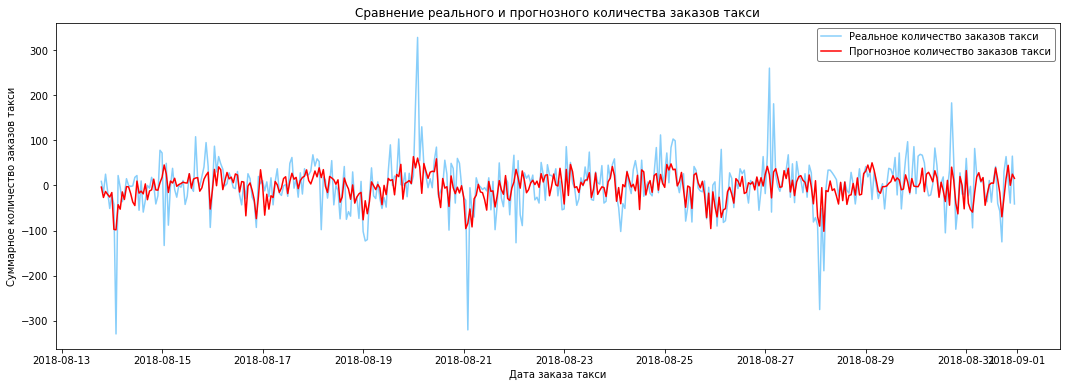

In [68]:
plt.figure(figsize = (18, 6))
plt.plot(target_test, label = "Реальное количество заказов такси", color = "lightskyblue")
plt.plot(prediction_df, label = "Прогнозное количество заказов такси", color = "red")
plt.title("Сравнение реального и прогнозного количества заказов такси")
plt.xlabel("Дата заказа такси")
plt.ylabel("Суммарное количество заказов такси")
plt.legend(loc = 0, framealpha = 1, edgecolor = "grey", shadow = None)
plt.show()

### Выводы
---
В данной работе:

1. Мы провели ресемплирование данных;
2. Выявили суточную и недельную сезонности в данных;
3. Оценили разные модели;
4. Выбрали лучшую модель и протестировал.

Важной частью работа является то, что в данных были обнаружены суточная и недельная сезонности. Несмотря на то, что тест Дики-Фуллера показал стационарность временного ряда, мы решили, что временной ряд все-таки является нестационарным по причине наличия тренда, двух видов сезонностей и изменения дисперсии со временем. Поэтому мы применили сезонную дифференциацию и привели временной ряд к стационарному виду. 

В результате лучшей моделью оказалась CatBoost-регрессия. На тестовой выборке RMSE составил 46.7733.